In [1]:
import torch
import torch.utils.data as torch_data

import losses
import trainer
from models import UNet
from utils import ColorizationDataset
import random
import numpy as np

SEED = 42
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

%load_ext autoreload
%autoreload 2
%matplotlib inline

/home/dfbakin/.cache/pypoetry/virtualenvs/colorizer-C6ZZGchb-py3.12/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Lenghths: 8 4 49988


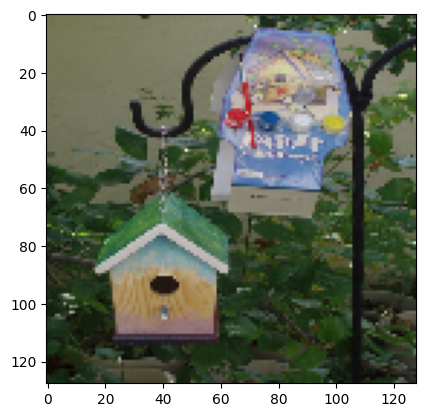

In [2]:
import matplotlib.pyplot as plt
import cv2

REQUIRED_SIZE = (128, 128)
combined_dataset = torch_data.ConcatDataset(
    [
        # ColorizationDataset("datasets/coco_2017_test", resize=REQUIRED_SIZE),
        ColorizationDataset(
            "datasets/imagenet_classes", resize=REQUIRED_SIZE, classes_folders=True
        ),
    ]
)

train_dataset, val_dataset, test_dataset = torch_data.random_split(
    combined_dataset, [8, 4, len(combined_dataset) - 8 - 4]
)  # debug lengths: 2034 407 38229
print("Lenghths:", *[len(item) for item in [train_dataset, val_dataset, test_dataset]])

L, ab = combined_dataset[0]
cielab_img = torch.cat([L * ColorizationDataset.l_norm_factor, ab * ColorizationDataset.ab_norm_factor], dim=0).numpy()
cielab_img = np.uint8(cielab_img.transpose(1, 2, 0))
rgb_img = cv2.cvtColor(cielab_img, cv2.COLOR_LAB2RGB)
plt.imshow(rgb_img)
plt.show()

In [3]:
batch_size = 8

train_loader = torch_data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=False, num_workers=8
)
val_loader = torch_data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=8
)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(1, 2).to(device)

criterion = losses.HuberLoss(1.0 / ColorizationDataset.ab_norm_factor)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
baseline_trainer = trainer.Trainer(
    model, optimizer, criterion, train_loader, val_dataloader=val_loader, device=device
)

[Train: 200] loss: 0.032


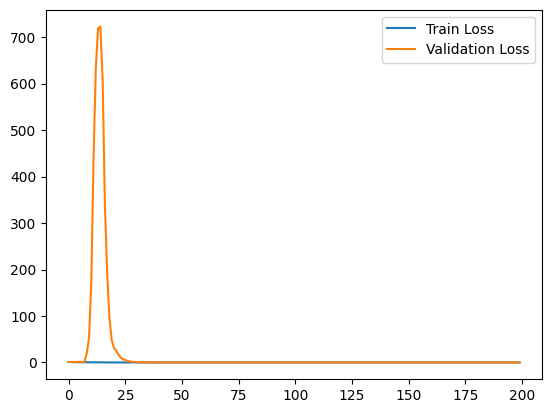

In [5]:
baseline_trainer.train(200)

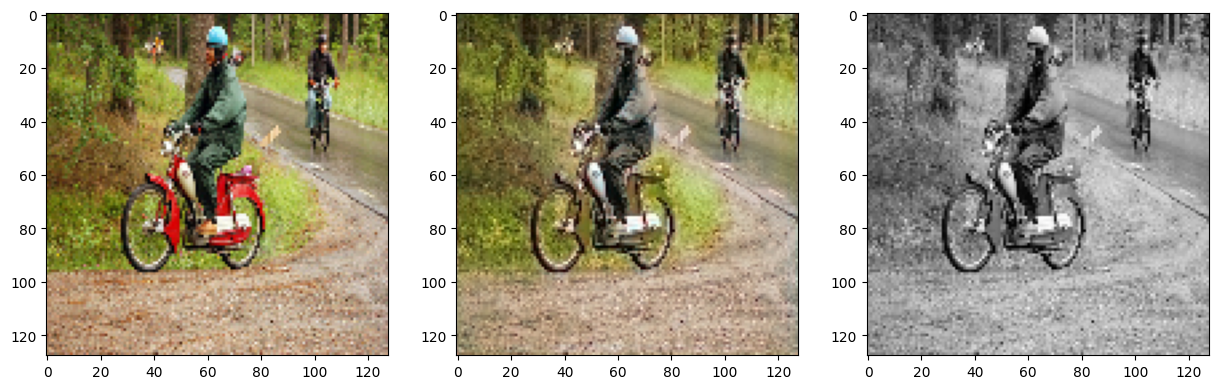

In [ ]:
def torch_L_ab_to_cvimage(L_input, ab_input):
    L = L_input * ColorizationDataset.l_norm_factor
    ab = ab_input * ColorizationDataset.ab_norm_factor
    
    cielab_img = torch.cat([L, ab], dim=0).numpy()
    cielab_img = cielab_img.transpose(1, 2, 0)
    cielab_img = np.clip(cielab_img, 0, 255).astype(np.uint8)
    return cv2.cvtColor(cielab_img, cv2.COLOR_LAB2RGB)

L, ab = train_dataset[0]
L = L.unsqueeze(0)
ab = ab.unsqueeze(0)

cielab_img_gt = torch_L_ab_to_cvimage(L.squeeze(0), ab.squeeze(0))
with torch.no_grad():
    model.eval()
    ab_prediction = model.forward(L.to(device))
    
cielab_img_pred = torch_L_ab_to_cvimage(L.squeeze(0), ab_prediction.to("cpu").squeeze(0))

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(cielab_img_gt)
ax[1].imshow(cielab_img_pred)
ax[2].imshow(L.squeeze(0).numpy().transpose(1, 2, 0), cmap="gray")
plt.show()